# random change in erodibility by fire

/home/kpierce/anaconda/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:267: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(color=color_for_closed)
/home/kpierce/anaconda/envs/espin/lib/python3.9/site-packages/landlab/plot/imshow.py:307: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


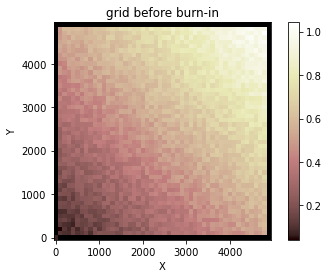

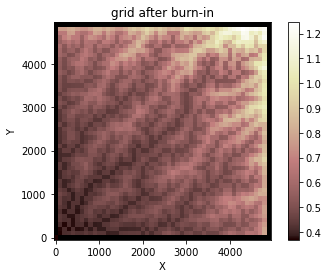

fire at (4700.0,900.0) with 34 nodes inflamed
-- 0 years -- 0.3 seconds --
fire at (1200.0,3000.0) with 1 nodes inflamed
fire at (3800.0,4300.0) with 1 nodes inflamed
fire at (800.0,3300.0) with 1 nodes inflamed
-- 1000 years -- 5.9 seconds --
fire at (0.0,4400.0) with 26 nodes inflamed
fire at (800.0,300.0) with 96 nodes inflamed
fire at (2400.0,4700.0) with 34 nodes inflamed
fire at (2000.0,1500.0) with 13 nodes inflamed
fire at (700.0,4000.0) with 1 nodes inflamed
fire at (3100.0,4500.0) with 1 nodes inflamed
fire at (1600.0,1100.0) with 81 nodes inflamed
-- 2000 years -- 11.5 seconds --
fire at (1900.0,3300.0) with 5 nodes inflamed
fire at (4500.0,2100.0) with 37 nodes inflamed
-- 3000 years -- 17.1 seconds --
fire at (2500.0,1300.0) with 5 nodes inflamed
fire at (400.0,3900.0) with 1 nodes inflamed
fire at (2800.0,3400.0) with 221 nodes inflamed
-- 4000 years -- 22.9 seconds --
fire at (2000.0,2100.0) with 1686 nodes inflamed
fire at (100.0,4400.0) with 84 nodes inflamed
fire at (

KeyboardInterrupt: 

In [1]:
%matplotlib inline
import numpy as np
from firemodel import *
import matplotlib.pyplot as plt 
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space,
                                ChannelProfiler # this makes plots
                               )
from landlab.io.netcdf import (write_netcdf, read_netcdf)
from create_network import create_network_from_raster # Shelby's code to make a channel network from a grid

from landlab import (RasterModelGrid,
                     imshow_grid)
%matplotlib inline
import time

save=True # save or not? 
save_dir = './simul/' # the place to save the output
dt = 50 # timestep in years
runtime = 100000 # length of the simulation in years
dx = 100 # size of a cell in ...m ? 
#np.random.seed(5000) # reproducible yet random

# 5x5 grid with baselevel in lower left corner
# all other boundary nodes closed
# init topography is plane tilted up to the upper right with noise

grid_dim = (50,50)
#grid_dim = (10,10)
mg = RasterModelGrid(grid_dim, xy_spacing=dx) # 3km x 3km 
_ = mg.add_zeros('topographic__elevation', at='node')
mg.at_node['topographic__elevation'] += (mg.node_y / 10000. + 
                                         mg.node_x / 10000. + np.random.rand(len(mg.node_y)) / 10.) # sloped up
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                        left_is_closed=True,
                                        right_is_closed=True,
                                        top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(
     0, mg.at_node['topographic__elevation'], -9999.)

# show the pre-burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid before burn-in')
plt.show()

#Instantiate Fastscape eroder, flow router, and depression finder
fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)
fsc = FastscapeEroder(
    mg,
    K_sp=.001,
    m_sp=.5,
    n_sp=1)

# burn in an initial drainage ntework using the fastscape eroder
for it in range(100):
    fr.run_one_step()
    df.map_depressions()
    fsc.run_one_step(dt=dt)
    mg.at_node['topographic__elevation'][0] -= 0.002 # Uplift
    
    
# add soil to the drainage network
_ = mg.add_zeros('soil__depth', at='node', dtype=float) 
mg.at_node['soil__depth'] += 0.5
mg.at_node['topographic__elevation'] += mg.at_node['soil__depth']


# plot after burn-in grid
mg.imshow('node','topographic__elevation')
plt.title('grid after burn-in')
plt.show()


# init the space component
K_sed0 = 0.00005 # the baseline soil erodiblity
K_sed = np.ones(mg.shape)*K_sed0 # the initial soil erodibility per node
ha = Space(
    mg,
    K_sed=K_sed,
    K_br=1e-10,
    F_f=0.5,
    phi=0.1,
    H_star=1.,
    v_s=0.001,
    m_sp=0.5,
    n_sp = 1.0,
    sp_crit_sed=0,
    sp_crit_br=0)


# init the erodibility stepper
decay_time = dt*3 # time it takes the erodibility perturbution to decay
es = ErodibilityStepper(decay_time=decay_time, K_sed0=K_sed0)
# this leads to decay in the erodibility from whatever value it's at.

# init the burner
R_fire_mean = grid_dim[0]/10*dx
fire_freq = 1/(7*dt)
K_sed_boost = 20*K_sed0
burner = Burner(fire_freq=fire_freq,
                R_fire_mean=R_fire_mean,
                K_sed_boost=K_sed_boost,
                dt=dt)
# this produces fires whick kick up the erodibility...


start_time = time.time()
for it in range(runtime//dt):
    fr.run_one_step() # accumulate the flow
    df.map_depressions() # find landscape depressions (which do not erode)
    ha.run_one_step(dt=dt) # step the transport model
    es.stepper(ha,dt=dt) # decay the erodibility back to baseline from the former timestep
    burner.fire(ha,mg) # light any fires (increase erodibility)
    mg.at_node['bedrock__elevation'][0] -= 3e-6*dt # add in the uplift
    if it*dt % 1000 == 0:
        print("--", it*dt, "years -- %s seconds --" % round((time.time() - start_time), 1))
    
    if (it*dt % 100 == 0) & save: # save every 100 years
        filename = save_dir + 'simul_%05d.nc'%it
        filename_npy = save_dir + 'simul_%05d'%it
        #mg.(filename, names='topographic__elevation')
        write_netcdf(filename, mg, format="NETCDF3_64BIT", names=["topographic__elevation","sediment__flux"])
        np.save(filename_npy, K_sed)
        
        
# plot after iteration grid
mg.imshow('node','topographic__elevation')
plt.title('grid after timesteppin')
plt.show()

#Show sediment flux map
fig = plt.figure()
plot = plt.subplot()
imshow_grid(mg, 'sediment__flux', plot_name='Sediment flux', var_name = 'Sediment flux', var_units=r'm$^3$/yr', grid_units=('m', 'm'), cmap='Blues')
plt.show()



# slope-area plot
area = mg.at_node['drainage_area'][mg.core_nodes]
slope = mg.at_node['topographic__steepest_slope'][mg.core_nodes]

fig = plt.figure()
slope_area_plot = plt.subplot()
slope_area_plot.set_xscale('log')
slope_area_plot.set_yscale('log')
plt.scatter(area, slope)
plt.show()


In [ ]:
nmg = create_network_from_raster(
    mg,
    method='variable', # method
    n_widths=dx,
    #node_spacing=30,
    #d_node_spacing=2*dx,
    min_channel_thresh=30000,
    fields=['drainage_area', 'topographic__elevation'])

from landlab.plot import graph

## Plot nodes
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
graph.plot_nodes(nmg)
plt.title("Nodes")

## Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(nmg,with_id=False,markersize=4)
graph.plot_links(nmg)
plt.title("Links")
plt.show()

# visualization learning . 

In [ ]:
mg.imshow('node','topographic__elevation')
#graph.plot_nodes(nmg,,markersize=4)
graph.plot_links(nmg,with_id=False)
fig = plt.gcf()
fig.set_size_inches(14, 10)

In [ ]:
def plotter(grid,K_sed):
    pinks = plt.get_cmap('pink') # pink colormap
    greys = plt.get_cmap('gist_gray')#plt.get_cmap('gist_gray') # grey colormap
    def cm_black(arr):
        return np.array([0,0,0,0.5]).astype('float')*np.ones_like(arr)[:,np.newaxis]
    #greys = cm_black
    # set up a blank image... 
    im = np.zeros(shape=(grid_dim[0],grid_dim[1],4))

    # get the elevations from the grid
    z = mg.at_node['topographic__elevation']
    zs = (z-z.min())/(z.max()-z.min())
    # determine "burned" locations in the image
    tol = K_sed0*1.5 # tolerance for "burned"
    mask = (K_sed > tol).flatten() # mask of places "burned"

    # get colors for burned locations
    #a = 0.9 #
    a = ((((K_sed-K_sed0)/K_sed_boost)).flatten())[mask][:,np.newaxis]
    a = (a+1)/2
    bvals = greys(zs[mask])*a + pinks(zs[mask])*(1-a)

    # get colors for not burned locations
    vals = pinks(zs[~mask])

    # fill in values within the image..
    smask = np.stack((mask.reshape(grid_dim[0],grid_dim[1]),)*4,-1)
    im[smask] = bvals.flatten()
    im[~smask] = vals.flatten()

    # fill in all edge nodes..
    def edge_mask(x):
        # https://stackoverflow.com/questions/48097068/how-to-get-boundaries-of-an-numpy-array
        mask = np.ones(x.shape, dtype=bool)
        mask[x.ndim * (slice(1, -1),)] = False
        return mask
    edge = edge_mask(im[:,:,0])
    im[edge]=np.array([0,0,0,1])

    # plot the image..
    x = np.linspace(0,dx*grid_dim[0],dx)
    y = np.linspace(0,dx*grid_dim[1],dx)
    #x,y = np.meshgrid(x,y)
    plt.imshow(im,extent=[x.min(),x.max(),y.min(),y.max()],origin='lower')
    
    graph.plot_links(nmg,with_id=False)


In [ ]:
plotter(mg,K_sed)

# loop to plot all timesteps

In [ ]:
import os
base = './simul/'
save = './imgs/'
files = sorted(os.listdir(base))
ks_files = [f for f in files if f[-3:] == 'npy']
mg_files = [f for f in files if f[-2:] == 'nc']
for f1,f2 in zip(ks_files,mg_files):
    f1p=base+f1
    f2=base+f2
    K_sed = np.load(f1p)
    mg = read_netcdf(f2)
    
    nmg = create_network_from_raster(
                                    mg,
                                    method='variable', # method
                                    n_widths=dx,
                                    #node_spacing=30,
                                    #d_node_spacing=2*dx,
                                    min_channel_thresh=30000,
                                    fields=['drainage_area', 'topographic__elevation']
                                    )
    plotter(mg,K_sed)
    fig = plt.gcf()
    fig.set_size_inches(8,8)
    savename = save + f1[:-3]+'png'
    fig.patch.set_facecolor('white')
    # add in timestamp
    #plt.text(,,'t = {}'.format(round()))
##################################### add in the text with the time
    t = int(f1.split('.')[0].split('_')[1])*dt
    plt.title('{} yr'.format(t),fontsize=20)
    plt.savefig(savename, dpi=100)
    plt.show()
    

# Nishani code to generate sediment flux


In [ ]:
import os
base = './simul/'
save = './imgs/'
files = sorted(os.listdir(base))
mg_files = [f for f in files if f[-2:] == 'nc']
fluxSeries = []
T = []
for f in mg_files:
    mg = read_netcdf(base+f)
    t = int(f.split('.')[0].split('_')[1])*dt
    flux = mg.at_node['sediment__flux']
    fluxSeries.append(flux.max())
    T.append(t)
T = np.array(T)

In [ ]:
plt.plot(T/1000,fluxSeries,color='black')
plt.xlabel('time [kyr]',fontsize=15)
plt.ylabel('Yield at outlet [$m^3$/yr]',fontsize=15)
plt.title('Sediment yield variations due to wildfire', fontsize=15)
fig = plt.gcf()
fig.set_size_inches(10,6)
fig.patch.set_facecolor('white')

plt.savefig('fireFlux.png')

# make a gif of the landscape evolution.

In [11]:
import imageio
import os
save = './imgs/'
files = sorted(os.listdir(save))

with imageio.get_writer('movie.mp4', mode='I',fps=12) as writer:
    for f in files:
        #print(f)
        im = imageio.imread(save+f)
        writer.append_data(im)